# Introduction

For most financial institutions, such as banks and multi-finance companies, their main source of income is coming from their lending activities. By
engaging in this activity, it means that lenders are exposed to the potential risk, where debtors stop repaying their loans, causing losses to the lenders. To mitigate this loss, lenders are expected to appropriately choose who are qualified for a loan, at what rate, and at what amount

In this notebook, I will take an initial look at the Loan Predict machine learning. The objective of this project is to use historical loan application data to predict whether or not an applicant will be able to repay a loan. This is a standard supervised classification task:

* __Supervised__: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features
* __Classification__: The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)

By the end of this project, the <b>objective</b> hoped to be achieved are:
- Able to determine the most important factor impacting client's with late payment.
- Predict whether customer will on-time/late payment.
- Give recommendation.

### Data

The data is provided by financial institutions, a service dedicated to provided lines of credit (loans) to the unbanked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need.

There are 3 different sources of data:

* app_train/app_test: the main training and testing data with information about each loan application. Every loan has its own row and is identified by the feature `LN_ID`. The training application data comes with the `TARGET` indicating 0: the loan was repaid or 1: the loan was not repaid. 
* previous_application: previous applications for loans of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature `SK_ID_PREV`. 
* installments_payment: payment history for previous loans. There is one row for every made payment and one row for every missed payment. 

This diagram shows how all of the data is related:

![alt text](credit.PNG "Credit")

Moreover, we are provided with the definitions of all the columns (in `columns_description.csv`) 

### Import Package

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, RUSBoostClassifier, EasyEnsembleClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, plot_roc_curve
import warnings
warnings.filterwarnings("ignore")

### Read Training & Testing Dataset

In [2]:
app_train = pd.read_csv('app_train.csv')
app_train.head()

,Unnamed: 0,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,...,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3
0,201468,333538,0,Revolving loans,F,1,67500.0,202500.0,10125.0,202500.0,...,-11539,-921,-119.0,-2757,TUESDAY,18,Business Entity Type 3,0.572805,0.608276,NaN
1,264803,406644,0,Cash loans,F,1,202500.0,976711.5,49869.0,873000.0,...,-15743,-4482,-1797.0,-2455,TUESDAY,14,Other,0.655600,0.684298,NaN
2,137208,259130,0,Cash loans,F,0,180000.0,407520.0,25060.5,360000.0,...,-20775,365243,-8737.0,-4312,THURSDAY,14,NA1,NaN,0.580687,0.749022
3,269220,411997,0,Cash loans,M,0,225000.0,808650.0,26086.5,675000.0,...,-20659,-10455,-4998.0,-4010,WEDNESDAY,10,Culture,NaN,0.623740,0.710674
4,122096,241559,0,Revolving loans,M,0,135000.0,180000.0,9000.0,180000.0,...,-9013,-1190,-3524.0,-1644,SUNDAY,11,Construction,0.175511,0.492994,0.085595


In [3]:
app_test = pd.read_csv('app_test.csv')
app_test.head()

,Unnamed: 0,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,...,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3
0,102590,219092,0,Cash loans,M,3,135000.0,871029.0,44604.0,765000.0,...,-17598,-2650,-1411.0,-1131,SATURDAY,7,Business Entity Type 3,NaN,0.145475,0.651260
1,35895,141577,0,Cash loans,F,0,144000.0,485640.0,34537.5,450000.0,...,-14097,-7408,-7908.0,-4872,MONDAY,14,Kindergarten,NaN,0.682675,NaN
2,69154,180205,0,Cash loans,F,1,90000.0,247500.0,8887.5,247500.0,...,-18384,-2826,-8226.0,-1930,SATURDAY,12,Self-employed,0.814700,0.686312,0.758393
3,222185,357381,0,Cash loans,M,2,112500.0,506889.0,24781.5,418500.0,...,-12170,-926,-916.0,-4048,THURSDAY,13,Other,0.399219,0.266520,0.058826
4,147680,271229,0,Cash loans,M,0,216000.0,450000.0,21888.0,450000.0,...,-10790,-577,-4640.0,-2035,MONDAY,14,Business Entity Type 3,0.368452,0.610483,0.392774


In [4]:
previous = pd.read_csv('prev_app.csv')
previous.head()

,Unnamed: 0,SK_ID_PREV,LN_ID,CONTRACT_TYPE,ANNUITY,APPLICATION,APPROVED_CREDIT,AMT_DOWN_PAYMENT,PRICE,WEEKDAYS_APPLY,HOUR_APPLY,CONTRACT_STATUS,DAYS_DECISION,TERM_PAYMENT,YIELD_GROUP,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Approved,-73,12.0,middle,365243.0,-42.0,-37.0,0.0
1,3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Approved,-512,12.0,middle,365243.0,-482.0,-177.0,1.0
2,5,1383531,199383,Cash loans,23703.930,315000.0,340573.5,NaN,315000.0,SATURDAY,8,Approved,-684,18.0,low_normal,365243.0,-654.0,-137.0,1.0
3,6,2315218,175704,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,11,Canceled,-14,NaN,NA1,NaN,NaN,NaN,NaN
4,10,1715995,447712,Cash loans,11368.620,270000.0,335754.0,NaN,270000.0,FRIDAY,7,Approved,-735,54.0,low_normal,365243.0,-705.0,-334.0,1.0


In [5]:
installments = pd.read_csv('installment_payment.csv')
installments.head()

,Unnamed: 0,SK_ID_PREV,LN_ID,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY
0,5,1137312,164489,12,-1384.0,-1417.0,5970.375,5970.375
1,8,2723183,112102,14,-197.0,-197.0,70.740,70.740
2,11,2558880,154793,8,-1262.0,-1269.0,15031.080,15031.080
3,17,1410565,197687,1,-1037.0,-1048.0,12514.050,12510.450
4,18,2391610,183431,20,-1680.0,-1693.0,7875.000,7875.000


# Exploratory Data Analysis

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data. The goal of EDA is to learn what our data can tell us.

### View shape of dataset & variable column names in dataset

In [6]:
print('Shape of training data :',app_train.shape)
print('Shape of training data :',app_test.shape)
print('Shape of previous data :',previous.shape)
print('Shape of installment data :',installments.shape)

Shape of training data : (61503, 24)
Shape of training data : (14761, 24)
Shape of previous data : (350712, 19)
Shape of installment data : (2872306, 8)


In [7]:
app_train.columns

Index(['Unnamed: 0', 'LN_ID', 'TARGET', 'CONTRACT_TYPE', 'GENDER',
       'NUM_CHILDREN', 'INCOME', 'APPROVED_CREDIT', 'ANNUITY', 'PRICE',
       'INCOME_TYPE', 'EDUCATION', 'FAMILY_STATUS', 'HOUSING_TYPE', 'DAYS_AGE',
       'DAYS_WORK', 'DAYS_REGISTRATION', 'DAYS_ID_CHANGE', 'WEEKDAYS_APPLY',
       'HOUR_APPLY', 'ORGANIZATION_TYPE', 'EXT_SCORE_1', 'EXT_SCORE_2',
       'EXT_SCORE_3'],
      dtype='object')

### Remove Collinear Features

In [8]:
app_train.dtypes.value_counts()

object     8
float64    8
int64      8
dtype: int64

In [9]:
app_train.select_dtypes('object').head()

,CONTRACT_TYPE,GENDER,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,WEEKDAYS_APPLY,ORGANIZATION_TYPE
0,Revolving loans,F,Working,Secondary / secondary special,Married,With parents,TUESDAY,Business Entity Type 3
1,Cash loans,F,Commercial associate,Secondary / secondary special,Married,House / apartment,TUESDAY,Other
2,Cash loans,F,Pensioner,Secondary / secondary special,Married,House / apartment,THURSDAY,NA1
3,Cash loans,M,State servant,Higher education,Married,House / apartment,WEDNESDAY,Culture
4,Revolving loans,M,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,SUNDAY,Construction


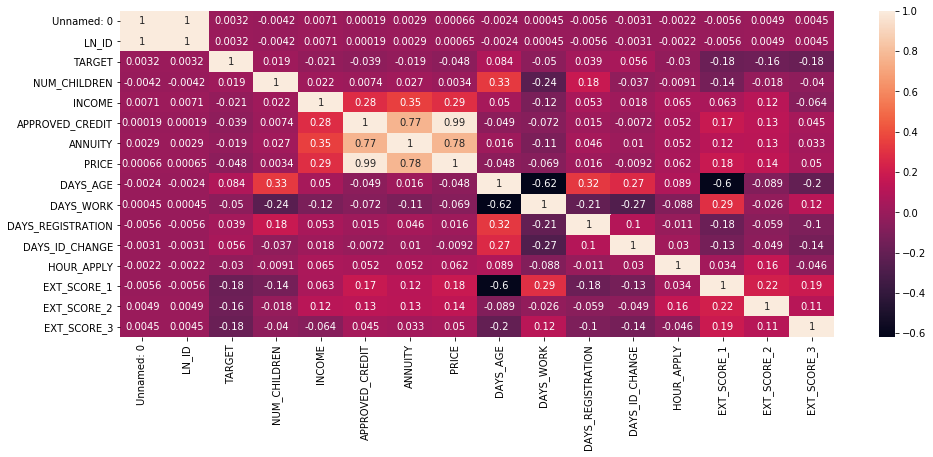

In [10]:
import seaborn as sb
plt.figure(figsize=(16,6))
sb.heatmap(app_train.corr(),annot=True)
plt.show()

We can see that the Unnamed feature didn't mean anything so we can drop the feature, while PRICE has a high correlation with APPROVED_CREDIT. Since APPROVED_CREDIT means the final amount credit that the company gives to the client and PRICE means the amount credit that the company should give to the clients, I prefer to choose the APPROVED_CREDIT feature by dropping PRICE feature. I also drop the WEEKDAYS_APPLY and ORGANIZATION_TYPE features because it decreases the AUC model score, I already test in another file and prove that.

In [11]:
app_train.drop(labels=['Unnamed: 0','PRICE','WEEKDAYS_APPLY','ORGANIZATION_TYPE'], axis=1, inplace=True)
app_test.drop(labels=['Unnamed: 0','PRICE','WEEKDAYS_APPLY','ORGANIZATION_TYPE'], axis=1, inplace=True)

In [12]:
previous.select_dtypes('object').head()

,CONTRACT_TYPE,WEEKDAYS_APPLY,CONTRACT_STATUS,YIELD_GROUP
0,Consumer loans,SATURDAY,Approved,middle
1,Cash loans,MONDAY,Approved,middle
2,Cash loans,SATURDAY,Approved,low_normal
3,Cash loans,TUESDAY,Canceled,NA1
4,Cash loans,FRIDAY,Approved,low_normal


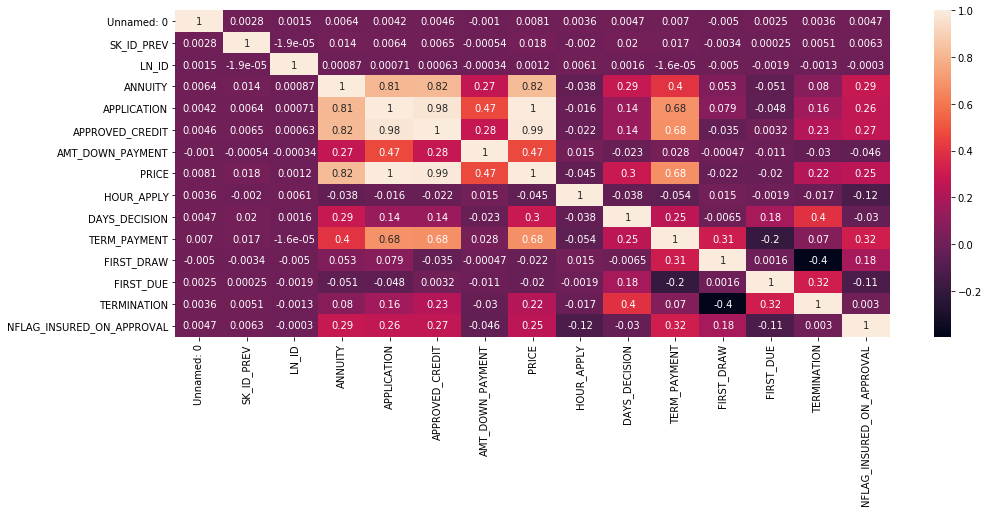

In [13]:
import seaborn as sb
plt.figure(figsize=(16,6))
sb.heatmap(previous.corr(),annot=True)
plt.show()

We can see that the Unnamed feature didn't mean anything so we can drop the feature, while ANNUITY, APPROVED_CREDIT, PRICE, HOUR APPLY, CONTRACT_TYPE, and WEEKDAYS_APPLY have already existed in the previous file so I drop the features because they don't have historical payment (clients on-time/late payment) when finally become to merge this file to the app_train/test. Since APPLICANT has a high correlation with APPROVED_CREDIT, I also need to drop that.

In [14]:
previous.drop(labels=['Unnamed: 0','APPLICATION','PRICE','ANNUITY','APPROVED_CREDIT','HOUR_APPLY','CONTRACT_TYPE','WEEKDAYS_APPLY'], axis=1, inplace=True)

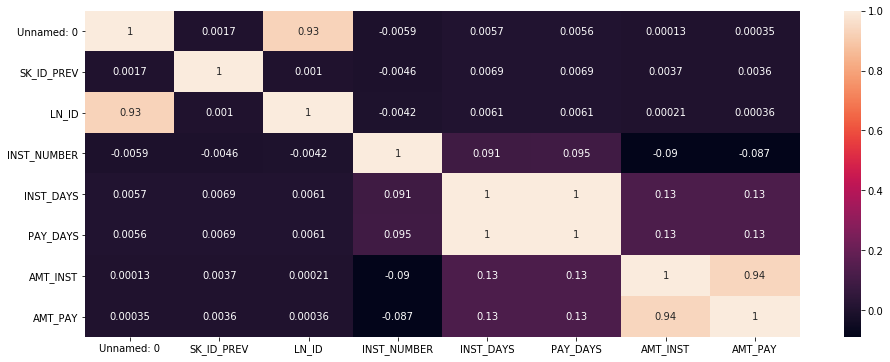

In [15]:
import seaborn as sb
plt.figure(figsize=(16,6))
sb.heatmap(installments.corr(),annot=True)
plt.show()

We can see that the Unnamed feature didn't mean anything so we can drop the feature, while INST_DAY has a high correlation with PAY_DAYS and AMT_INST with AMT_PAY. Since INST_DAYS means when the clients should be paid previous loan and PAY_DAYS means when the clients finally paid the previous loan, and AMT_INST means what amount clients should be paid previous loan and AMT_PAY means what amount the clients finally paid the previous loan. I prefer to choose the PAY_DAYS and AMT_PAY features by dropping INST_DAY and AMT_INST features.

In [16]:
installments.drop(labels=['Unnamed: 0','LN_ID', 'INST_DAYS','AMT_INST'], axis=1, inplace=True)

### Dealing with Outliers

One problem we always want to be on the lookout for when doing EDA is anomalies/outliers within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the `boxplot` or `describe` method. 

As we know that data in the financial institution have many client characteristics, for INCOME, APPROVED_CREDIT, and ANNUITY it might for someone to have a huge amount of value number(outlier). So, I tried to keep the outlier and only change a little if it needed

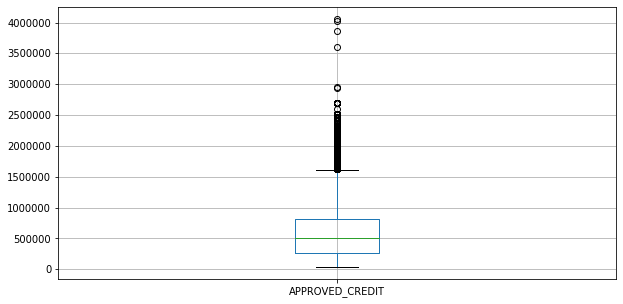

In [17]:
app_train.boxplot(column=['APPROVED_CREDIT'], figsize=(10,5))

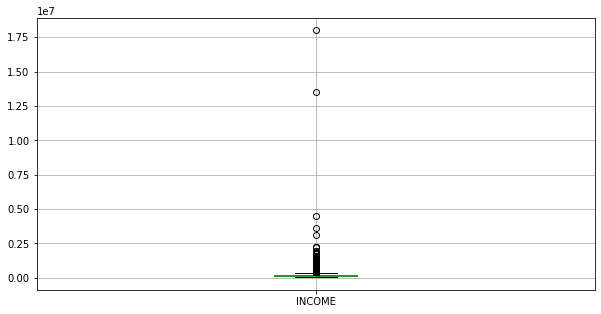

In [18]:
app_train.boxplot(column=['INCOME'], figsize=(10,5))

As we see that income feature has two outliers data that much higher than any other data. So, I will analyze the data and replace the value number if it needed

In [19]:
app_train[(app_train['INCOME']==app_train['INCOME'].max())]

,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,HOUR_APPLY,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3
27063,336147,0,Cash loans,M,2,18000090.0,675000.0,69295.5,Commercial associate,Secondary / secondary special,Married,House / apartment,-15704,-4961,-3338.0,-4728,22,0.543417,0.788606,NaN


In [20]:
dum = app_train[(app_train['APPROVED_CREDIT']==675000) & (app_train['ANNUITY']==69295.5)]
dum['INCOME'].value_counts()

315000.0      2
306000.0      1
427500.0      1
18000090.0    1
225000.0      1
202500.0      1
180000.0      1
238500.0      1
Name: INCOME, dtype: int64

In [21]:
dum['INCOME'].median()

306000.0

In [22]:
app_train['INCOME'][27063] = 360000.0

In this step, I replace the higher outlier data with the median of data based on specific approved credit and annuity value numbers

In [23]:
app_train[(app_train['INCOME']==app_train['INCOME'].max())]

,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,HOUR_APPLY,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3
55124,385674,0,Cash loans,M,0,13500000.0,1400503.5,130945.5,Commercial associate,Higher education,Married,House / apartment,-13551,-280,-3953.0,-4972,12,NaN,0.713507,NaN


In [24]:
dum1 = app_train[(app_train['APPROVED_CREDIT']==1400503.5) & (app_train['ANNUITY']==130945.5)]
dum1['INCOME'].value_counts()

13500000.0    1
Name: INCOME, dtype: int64

In [25]:
app_train['INCOME'][55124] = np.nan

In [26]:
app_train[(app_train['INCOME']==app_train['INCOME'].max())]

,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,HOUR_APPLY,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3
39217,317748,0,Cash loans,M,0,4500000.0,835380.0,42651.0,Working,Secondary / secondary special,Married,House / apartment,-18715,-3331,-8877.0,-2104,13,NaN,0.748822,0.282248


In [27]:
app_train['INCOME'][55124] = 4500000.0

In this step, I replace the second-highest outlier to the null values first then replaced it again to the highest number outliers after that

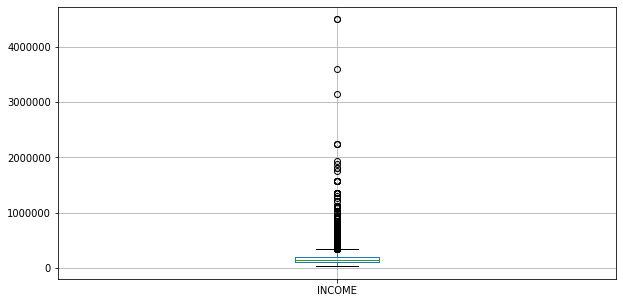

In [28]:
app_train.boxplot(column=['INCOME'], figsize=(10,5))

This boxplot have seen more realistic when each outliers data distribution has no more distinguish value number

In [29]:
app_train['DAYS_WORK'].describe()

count     61503.000000
mean      64882.262768
std      142154.440320
min      -17912.000000
25%       -2761.000000
50%       -1208.000000
75%        -276.000000
max      365243.000000
Name: DAYS_WORK, dtype: float64

That doesn't look right because the maximum value is about 1000 years

In [30]:
# Replace the anomalous values with nan
app_train['DAYS_WORK'].replace({365243: np.nan}, inplace = True)
app_test['DAYS_WORK'].replace({365243: np.nan}, inplace = True)

In [31]:
app_train['DAYS_WORK'].fillna(app_train['DAYS_WORK'].median(), inplace=True)
app_test['DAYS_WORK'].fillna(app_test['DAYS_WORK'].median(), inplace=True)

In [32]:
previous['FIRST_DRAW'].describe()

count    211407.000000
mean     342238.632122
std       88866.480608
min       -2922.000000
25%      365243.000000
50%      365243.000000
75%      365243.000000
max      365243.000000
Name: FIRST_DRAW, dtype: float64

In [33]:
previous['FIRST_DUE'].describe()

count    211407.000000
mean      13228.355887
std       71030.663471
min       -2892.000000
25%       -1625.000000
50%        -825.000000
75%        -408.000000
max      365243.000000
Name: FIRST_DUE, dtype: float64

In [34]:
previous['TERMINATION'].describe()

count    211407.000000
mean      82378.742109
std      153553.036032
min       -2845.000000
25%       -1267.000000
50%        -495.000000
75%         -43.000000
max      365243.000000
Name: TERMINATION, dtype: float64

In [35]:
previous['TERMINATION'].replace({365243: np.nan}, inplace = True)
previous['FIRST_DRAW'].replace({365243: np.nan}, inplace = True)
previous['FIRST_DUE'].replace({365243: np.nan}, inplace = True)

In [36]:
previous['TERMINATION'].fillna(previous['TERMINATION'].median(), inplace=True)
previous['FIRST_DRAW'].fillna(previous['FIRST_DRAW'].median(), inplace=True)
previous['FIRST_DUE'].fillna(previous['FIRST_DUE'].median(), inplace=True)

### Examine Missing Values

Next, we can look at the number and percentage of missing values in each column. In this file, I decided to treat missing values by drop the columns since I already compared with another method and find that this way is better when compare in AUC model score

In [37]:
def missing_values(df):
        missing_value = df.isnull().sum()
        missing_value_percent = 100 * df.isnull().sum() / len(df)
        missing_value_table = pd.concat([missing_value, missing_value_percent], axis=1)
        missing_value_table_columns = missing_value_table.rename(columns = {0 : 'Missing Values', 1 : 'Percentage'})
        missing_value_table_columns = missing_value_table_columns[
        missing_value_table_columns.iloc[:,1] != 0].sort_values('Percentage', ascending=False).round(1)
        return missing_value_table_columns
    
missing_values(app_train)

,Missing Values,Percentage
EXT_SCORE_1,34845,56.7
EXT_SCORE_3,12239,19.9
EXT_SCORE_2,134,0.2
ANNUITY,1,0.0


In [38]:
missing_values(app_test)

,Missing Values,Percentage
EXT_SCORE_1,8312,56.3
EXT_SCORE_3,2919,19.8
EXT_SCORE_2,19,0.1


In [39]:
app_train = app_train.dropna()
app_test = app_test.dropna()

In [40]:
missing_values(previous)

,Missing Values,Percentage
AMT_DOWN_PAYMENT,186507,53.2
NFLAG_INSURED_ON_APPROVAL,139305,39.7
TERM_PAYMENT,76609,21.8


In [41]:
previous = previous.dropna()

In [42]:
missing_values(installments)

,Missing Values,Percentage
PAY_DAYS,673,0.0
AMT_PAY,673,0.0


In [43]:
installments = installments.dropna()

### Merge All Files

In [44]:
previous.head()

,SK_ID_PREV,LN_ID,AMT_DOWN_PAYMENT,CONTRACT_STATUS,DAYS_DECISION,TERM_PAYMENT,YIELD_GROUP,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,0.0,Approved,-73,12.0,middle,-630.0,-42.0,-37.0,0.0
5,1151694,161591,13500.0,Approved,-989,6.0,middle,-630.0,-958.0,-804.0,0.0
6,2057616,304455,9000.0,Approved,-406,10.0,middle,-630.0,-374.0,-101.0,0.0
7,2586290,447421,25312.5,Approved,-243,12.0,middle,-630.0,-212.0,-116.0,0.0
9,1946657,427532,0.0,Approved,-1327,24.0,low_action,-630.0,-1296.0,-990.0,0.0


In [45]:
app_train = app_train.merge(previous, on ='LN_ID', how = 'left')
app_test = app_test.merge(previous, on ='LN_ID', how = 'left')

In [46]:
app_train.columns

Index(['LN_ID', 'TARGET', 'CONTRACT_TYPE', 'GENDER', 'NUM_CHILDREN', 'INCOME',
       'APPROVED_CREDIT', 'ANNUITY', 'INCOME_TYPE', 'EDUCATION',
       'FAMILY_STATUS', 'HOUSING_TYPE', 'DAYS_AGE', 'DAYS_WORK',
       'DAYS_REGISTRATION', 'DAYS_ID_CHANGE', 'HOUR_APPLY', 'EXT_SCORE_1',
       'EXT_SCORE_2', 'EXT_SCORE_3', 'SK_ID_PREV', 'AMT_DOWN_PAYMENT',
       'CONTRACT_STATUS', 'DAYS_DECISION', 'TERM_PAYMENT', 'YIELD_GROUP',
       'FIRST_DRAW', 'FIRST_DUE', 'TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

In [47]:
print(app_train.shape)
print(app_test.shape)

(44604, 30)
(10719, 30)


In [48]:
missing_values(app_train)

,Missing Values,Percentage
SK_ID_PREV,2313,5.2
AMT_DOWN_PAYMENT,2313,5.2
CONTRACT_STATUS,2313,5.2
DAYS_DECISION,2313,5.2
TERM_PAYMENT,2313,5.2
YIELD_GROUP,2313,5.2
FIRST_DRAW,2313,5.2
FIRST_DUE,2313,5.2
TERMINATION,2313,5.2
NFLAG_INSURED_ON_APPROVAL,2313,5.2


After merging the data, we find missing values mean that LN_ID in app_train/test didn't all have a previous loan history. So I decided to treat the missing values by filling with a mode value in categorical features and fill with zero in numerical features

In [49]:
app_train['CONTRACT_STATUS'].fillna(app_train['CONTRACT_STATUS'].mode()[0], inplace=True)
app_train['YIELD_GROUP'].fillna(app_train['YIELD_GROUP'].mode()[0], inplace=True)

app_test['CONTRACT_STATUS'].fillna(app_test['CONTRACT_STATUS'].mode()[0], inplace=True)
app_test['YIELD_GROUP'].fillna(app_train['YIELD_GROUP'].mode()[0], inplace=True)

In [50]:
app_train = app_train.fillna(0)
app_test = app_test.fillna(0)

In [51]:
app_train['SK_ID_PREV'] = app_train['SK_ID_PREV'].astype('int64')
app_test['SK_ID_PREV'] = app_test['SK_ID_PREV'].astype('int64')

In [52]:
installments.head()

,SK_ID_PREV,INST_NUMBER,PAY_DAYS,AMT_PAY
0,1137312,12,-1417.0,5970.375
1,2723183,14,-197.0,70.740
2,2558880,8,-1269.0,15031.080
3,1410565,1,-1048.0,12510.450
4,2391610,20,-1693.0,7875.000


In [53]:
app_train = app_train.merge(installments, on ='SK_ID_PREV', how = 'left')
app_test = app_test.merge(installments, on ='SK_ID_PREV', how = 'left')

In [54]:
app_train.columns

Index(['LN_ID', 'TARGET', 'CONTRACT_TYPE', 'GENDER', 'NUM_CHILDREN', 'INCOME',
       'APPROVED_CREDIT', 'ANNUITY', 'INCOME_TYPE', 'EDUCATION',
       'FAMILY_STATUS', 'HOUSING_TYPE', 'DAYS_AGE', 'DAYS_WORK',
       'DAYS_REGISTRATION', 'DAYS_ID_CHANGE', 'HOUR_APPLY', 'EXT_SCORE_1',
       'EXT_SCORE_2', 'EXT_SCORE_3', 'SK_ID_PREV', 'AMT_DOWN_PAYMENT',
       'CONTRACT_STATUS', 'DAYS_DECISION', 'TERM_PAYMENT', 'YIELD_GROUP',
       'FIRST_DRAW', 'FIRST_DUE', 'TERMINATION', 'NFLAG_INSURED_ON_APPROVAL',
       'INST_NUMBER', 'PAY_DAYS', 'AMT_PAY'],
      dtype='object')

In [55]:
print(app_train.shape)
print(app_test.shape)

(398039, 33)
(95046, 33)


In [56]:
missing_values(app_train)

,Missing Values,Percentage
INST_NUMBER,2768,0.7
PAY_DAYS,2768,0.7
AMT_PAY,2768,0.7


In [57]:
app_train = app_train.fillna(0)
app_test = app_test.fillna(0)

### Distribution of the Target Column

The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties

In [58]:
print(app_train['TARGET'].value_counts())

0    371339
1     26700
Name: TARGET, dtype: int64


Text(0, 0.5, 'Count of Applicants')

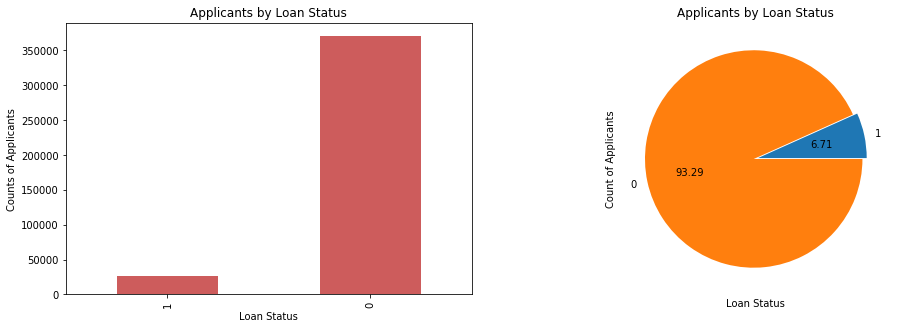

In [59]:
temp1 = app_train['TARGET'].value_counts(ascending=True)

plt.figure(figsize=(16,11))
plt.subplot(221)
temp1.plot(kind='bar', color='indianred')
plt.title("Applicants by Loan Status")
plt.xlabel('Loan Status')
plt.ylabel('Counts of Applicants')

plt.subplot(222)
temp1.plot(kind='pie', autopct='%.2f', explode=(.02,.02))
plt.title("Applicants by Loan Status")
plt.xlabel('Loan Status')
plt.ylabel('Count of Applicants')

### Analyze by Categorical Features

Let's see the type of the loans taken and also, on a separate plot, the percent of the loans (by type of the loan) with TARGET value 1 (indicating the client had payment difficulties)

In [60]:
def plot_stats(feature, label_rotation=False, horizontal_layout=True):
    temp = app_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = app_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.show()

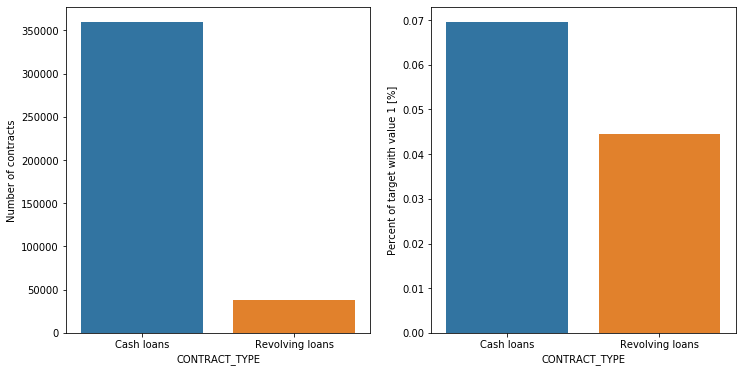

In [61]:
plot_stats('CONTRACT_TYPE')

We see that Revolving loans are just a small fraction (~15%) from the total number of loans. At the same time a larger amount of Revolving loans, compared with their frequency, are not repaid.

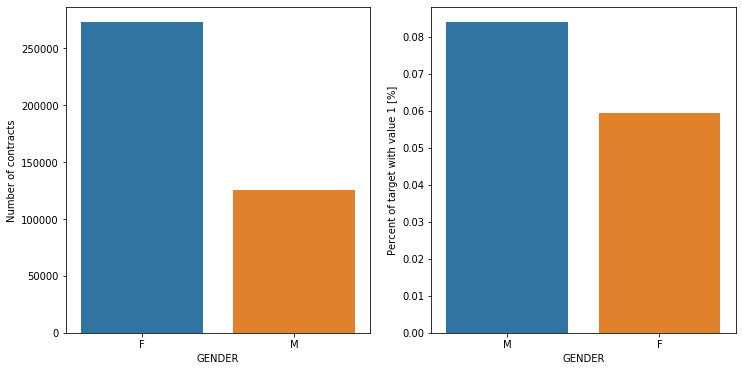

In [62]:
plot_stats('GENDER')

The number of female clients is almost double the number of male clients. Looking at the percent of defaulted credits, males have a higher chance of not returning their loans (9%), comparing with women (6%).

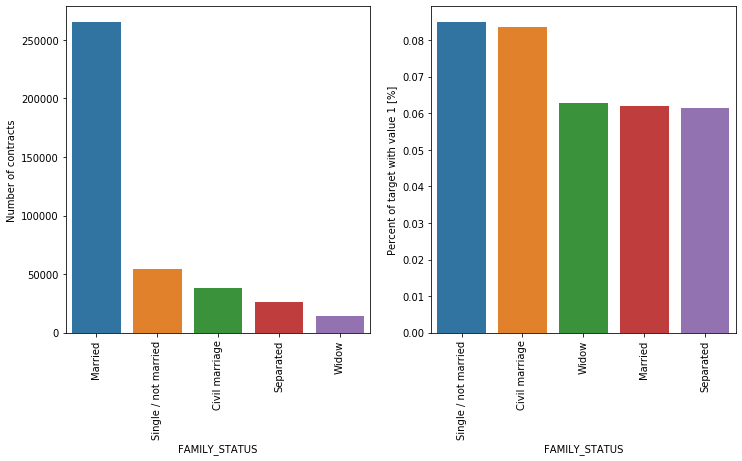

In [63]:
plot_stats('FAMILY_STATUS',True)

Most of the clients are married, followed by Single/not married and civil marriage.

In terms of percentage of not repayment of a loan, Single and Civil marriage has the highest percent of not repayment (9%), with Separated the lowest.

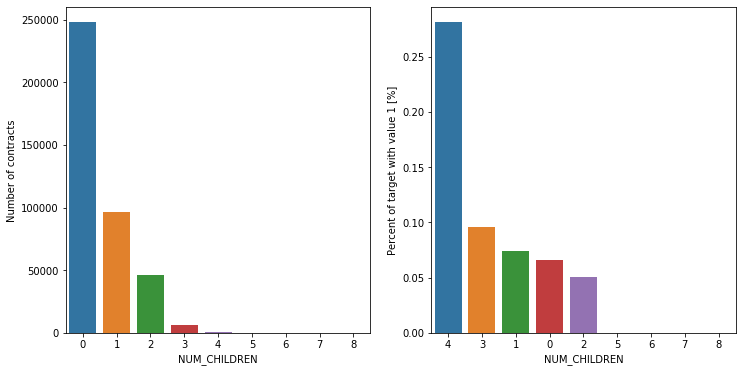

In [64]:
plot_stats('NUM_CHILDREN')

Most of the clients taking a loan have no children. The number of loans associated with the clients with one child are 2,5 times smaller, the number of loans associated with the clients with two children is 5 times smaller; clients with 3, 4 or more children are much rarer.

As for repayment, clients with no children, 1, 2, 3, and 5 children have percent of no repayment below 10%. The clients with 4 children are above average in terms of percent of not paid back loans (over 25% for families with 4 children).

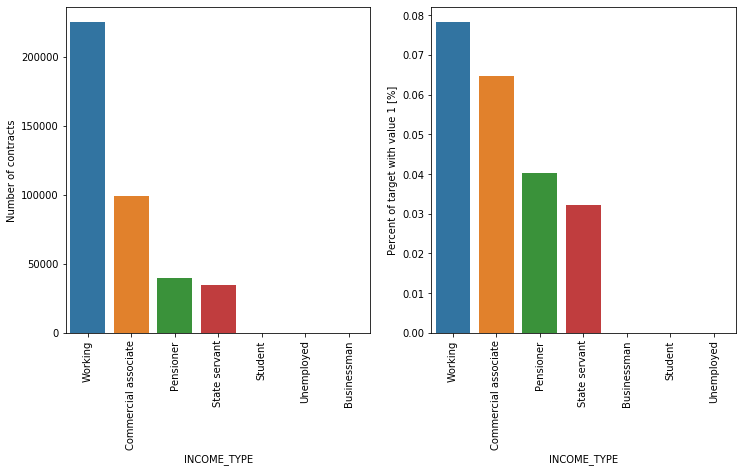

In [65]:
plot_stats('INCOME_TYPE',True)

Most of the applicants for loans are income from Working, followed by Commercial associate, Pensioner, and State servant.

The applicants with the type of income Working have almost 8% ratio of not returning loans, followed by Commercial Associate (~7%)

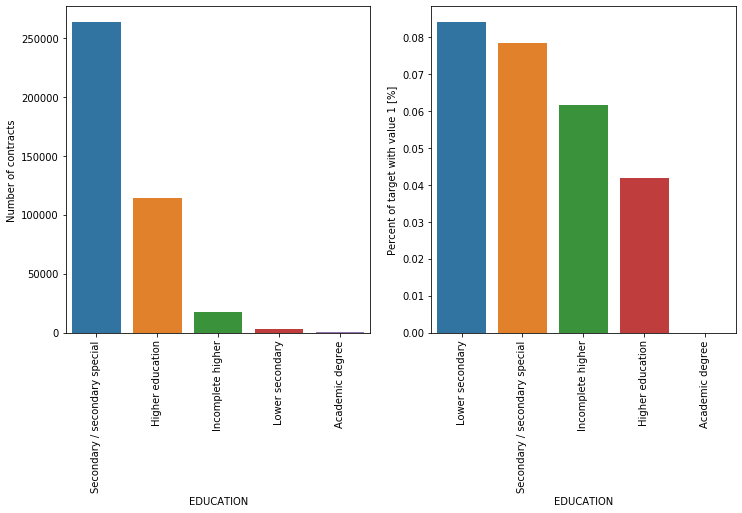

In [66]:
plot_stats('EDUCATION',True)

The majority of the clients have Secondary/secondary special education, followed by clients with Higher education. Only a very small number having an academic degree.

The Lower secondary category, although rare, have the largest rate of not returning the loan (9%). The people with Academic degrees have less than 1% not-repayment rate.

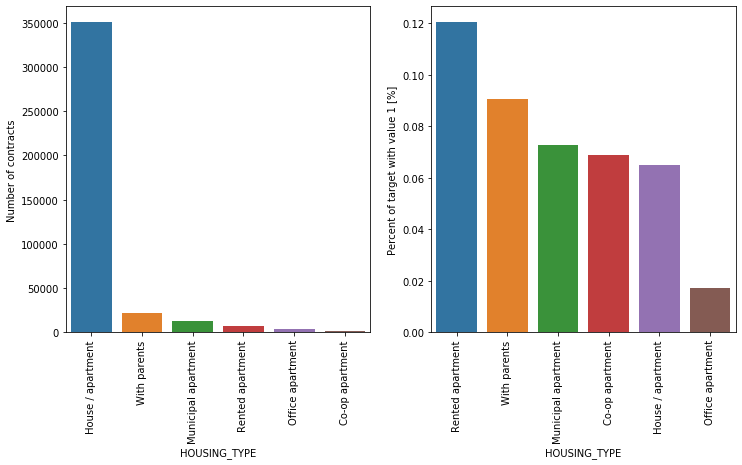

In [67]:
plot_stats('HOUSING_TYPE',True)

Over 350,000 applicants for credits registered their housing as House/apartment. The following categories have a very small number of clients (With parents, Municipal apartments).

From these categories, the Rented apartment has a higher than 10% not-repayment rate.

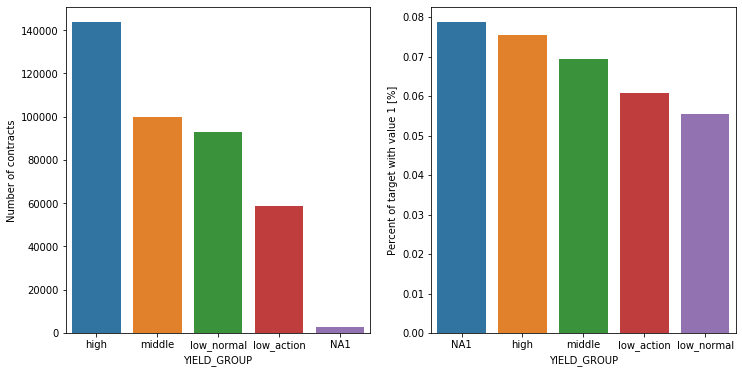

In [68]:
plot_stats('YIELD_GROUP')

Most of the applicants interest rate for loans are High, followed by middle, low normal, and low action.

The NA1 category, although rare, have the largest rate of not returning the loan (~8%). followed by High, middle and low action

### Analyze by Numerical Features

In [69]:
# Plot distribution of one feature
def plot_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(app_train[feature],color=color, kde=True,bins=100)
    plt.show()   

In [70]:
app_train.columns

Index(['LN_ID', 'TARGET', 'CONTRACT_TYPE', 'GENDER', 'NUM_CHILDREN', 'INCOME',
       'APPROVED_CREDIT', 'ANNUITY', 'INCOME_TYPE', 'EDUCATION',
       'FAMILY_STATUS', 'HOUSING_TYPE', 'DAYS_AGE', 'DAYS_WORK',
       'DAYS_REGISTRATION', 'DAYS_ID_CHANGE', 'HOUR_APPLY', 'EXT_SCORE_1',
       'EXT_SCORE_2', 'EXT_SCORE_3', 'SK_ID_PREV', 'AMT_DOWN_PAYMENT',
       'CONTRACT_STATUS', 'DAYS_DECISION', 'TERM_PAYMENT', 'YIELD_GROUP',
       'FIRST_DRAW', 'FIRST_DUE', 'TERMINATION', 'NFLAG_INSURED_ON_APPROVAL',
       'INST_NUMBER', 'PAY_DAYS', 'AMT_PAY'],
      dtype='object')

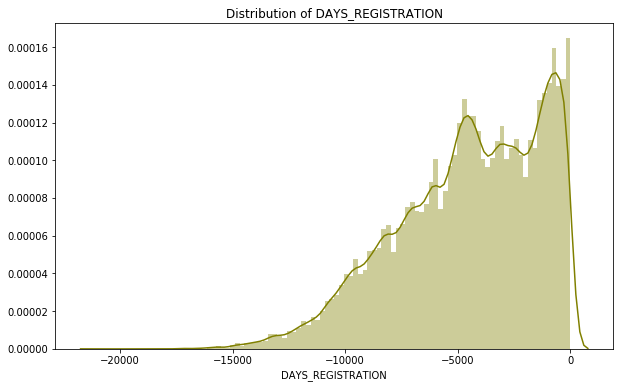

In [71]:
plot_distribution('DAYS_REGISTRATION','olive')

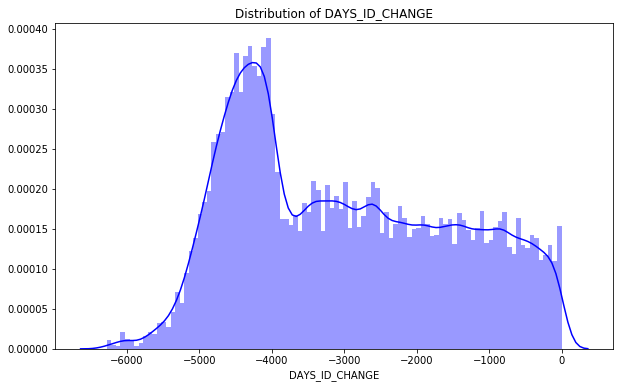

In [72]:
plot_distribution('DAYS_ID_CHANGE','blue')

#### Comparison of interval values with TARGET = 1 and TARGET = 0

Let's compare the distribution of interval values ploted above for values of TARGET = 1 and TARGET = 0

In [73]:
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_distribution_comp(var,nrow):
    
    i = 0
    target0 = app_train.loc[app_train['TARGET'] == 0]
    target1 = app_train.loc[app_train['TARGET'] != 0]
    
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(16,14))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(target1[feature], bw=0.5, label="TARGET = 1")
        sns.kdeplot(target0[feature], bw=0.5, label="TARGET = 0")
        
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
        
    plt.show()

<Figure size 432x288 with 0 Axes>

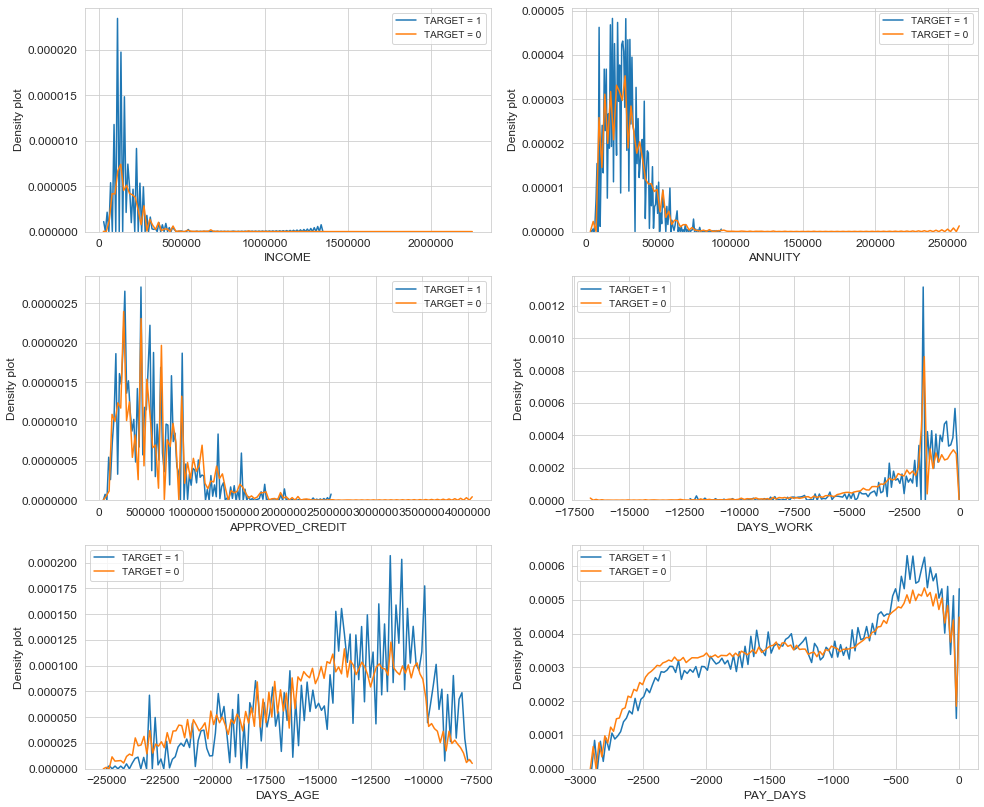

In [74]:
listvar = ['INCOME','ANNUITY','APPROVED_CREDIT','DAYS_WORK','DAYS_AGE','PAY_DAYS']
plot_distribution_comp(listvar,nrow=3)

##### Insight

- It shows that all of the numerical features have the same data distribution pattern if we're doing a comparison with Target
- We also can see __if we're dropping the clients with some specific criteria in all of the numerical feature, we could lose not only client's late payment but also client's with on-time payment__

### Correlations

Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the `.corr` dataframe method.


* 00 - 19 “very weak”
* 20 - 39 “weak”
* 40 - 59 “moderate”
* 60 - 79 “strong”
* 80 - 1.0 “very strong”


In [75]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(10))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 FIRST_DRAW           0.009433
TERMINATION          0.020899
PAY_DAYS             0.021446
DAYS_DECISION        0.021687
FIRST_DUE            0.021787
DAYS_REGISTRATION    0.024597
DAYS_ID_CHANGE       0.045725
DAYS_WORK            0.063290
DAYS_AGE             0.078777
TARGET               1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SCORE_1                 -0.175990
EXT_SCORE_3                 -0.173234
EXT_SCORE_2                 -0.138286
APPROVED_CREDIT             -0.036063
INCOME                      -0.031017
HOUR_APPLY                  -0.029276
AMT_DOWN_PAYMENT            -0.020934
AMT_PAY                     -0.020431
ANNUITY                     -0.015676
NFLAG_INSURED_ON_APPROVAL   -0.005442
Name: TARGET, dtype: float64


Let's take a look at some of more significant correlations: the DAYS_AGE is the most positive correlation. (except for TARGET because the correlation of a variable with itself is always 1!) 

Looking at the documentation, `DAYS_AGE` is the age in days of the client at the time of the loan in negative days. The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0). That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.

In [76]:
app_train['DAYS_AGE'] = abs(app_train['DAYS_AGE'])
app_test['DAYS_AGE'] = abs(app_test['DAYS_AGE'])

In [77]:
# Find the correlation of the positive days since birth and target
print(app_train['DAYS_AGE'].corr(app_train['TARGET']))

-0.0787767148213635


As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often. 

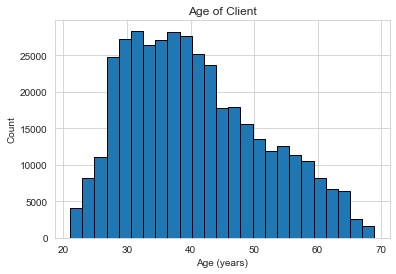

In [78]:
# Plot the distribution of ages in years
plt.hist(app_train['DAYS_AGE'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

Let's look average failure to repay loans by age bracket. 

To make this graph, first we cut the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [79]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_AGE']]
age_data['YEARS_BIRTH'] = age_data['DAYS_AGE'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_AGE,YEARS_BIRTH,YEARS_BINNED
0,0,9013,24.693151,"(20.0, 25.0]"
1,0,9013,24.693151,"(20.0, 25.0]"
2,0,9013,24.693151,"(20.0, 25.0]"
3,0,9013,24.693151,"(20.0, 25.0]"
4,0,9013,24.693151,"(20.0, 25.0]"
5,0,9013,24.693151,"(20.0, 25.0]"
6,0,9013,24.693151,"(20.0, 25.0]"
7,0,9013,24.693151,"(20.0, 25.0]"
8,0,9013,24.693151,"(20.0, 25.0]"
9,0,9013,24.693151,"(20.0, 25.0]"


In [80]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_AGE,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.126988,8550.246063,23.425332
"(25.0, 30.0]",0.091109,10213.082402,27.981048
"(30.0, 35.0]",0.084230,11839.665707,32.437440
"(35.0, 40.0]",0.069925,13694.278829,37.518572
"(40.0, 45.0]",0.047391,15459.907099,42.355910
"(45.0, 50.0]",0.061334,17308.259896,47.419890
"(50.0, 55.0]",0.051824,19166.984592,52.512287
"(55.0, 60.0]",0.040318,20973.526885,57.461717
"(60.0, 65.0]",0.037337,22799.642663,62.464774


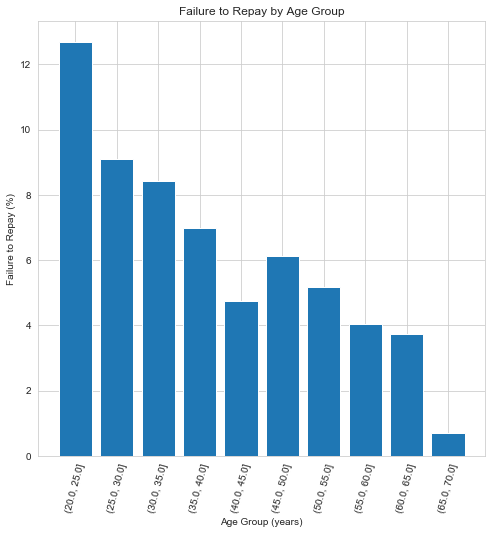

In [81]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

##### Insight

- There is a clear trend, __younger applicants are more likely to not repay the loan!__ The rate of failure to repay is above 10% for the youngest three age groups and below 5% for the oldest age group.

- This is information that could be directly used by the financial institution: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the financial institution should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

# Feature Engineering

Feature engineering refers to a geneal process and can involve both feature construction: adding new features from the existing data, and feature selection: choosing only the most important features or other methods.

### Remove Redundant & Collinear Feature

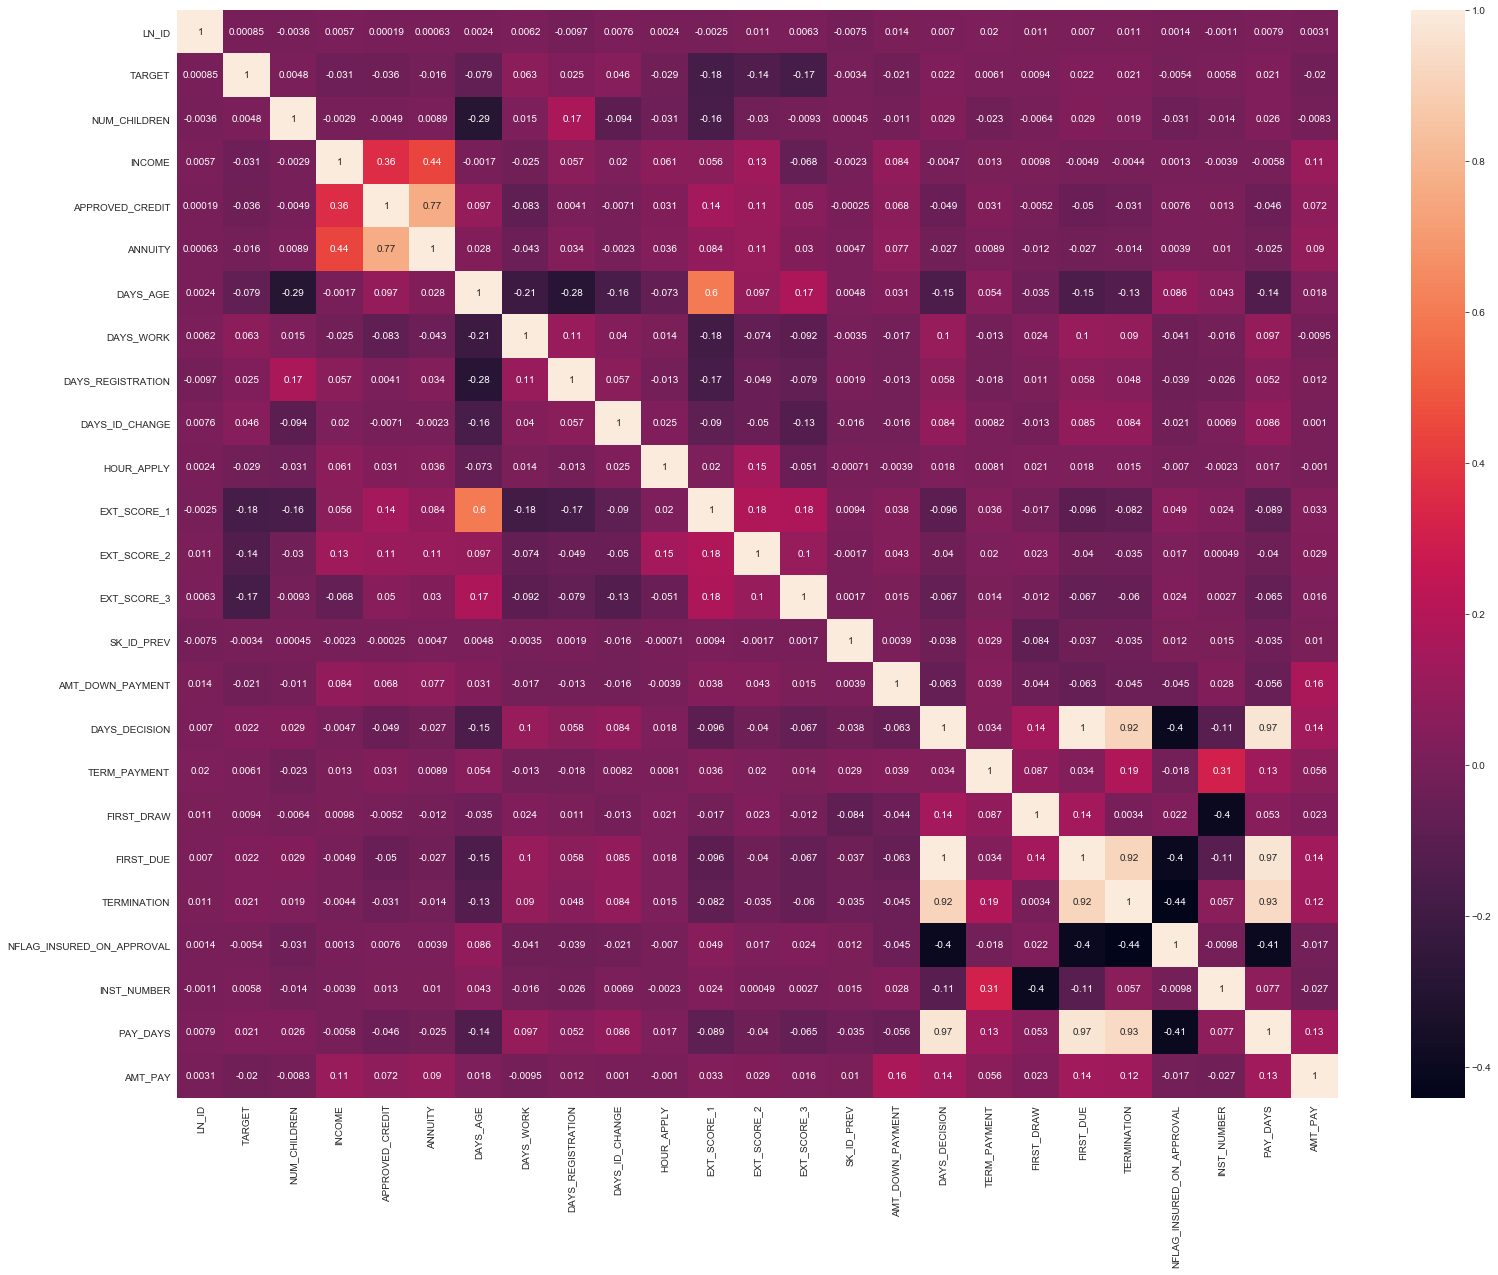

In [82]:
import seaborn as sb
plt.figure(figsize=(26,20))
sb.heatmap(app_train.corr(),annot=True)
plt.show()

I tried to reduce several features by dropping the feature with correlation to TARGET <1% and remove collinear feature with PAY_DAYS 

In [83]:
app_train.drop(labels=['LN_ID', 'SK_ID_PREV','NUM_CHILDREN','DAYS_DECISION','TERM_PAYMENT','FIRST_DRAW','FIRST_DUE','TERMINATION','NFLAG_INSURED_ON_APPROVAL','INST_NUMBER'], axis=1, inplace=True)
app_test.drop(labels=['LN_ID', 'SK_ID_PREV','NUM_CHILDREN','DAYS_DECISION','TERM_PAYMENT','FIRST_DRAW','FIRST_DUE','TERMINATION','NFLAG_INSURED_ON_APPROVAL','INST_NUMBER'], axis=1, inplace=True)

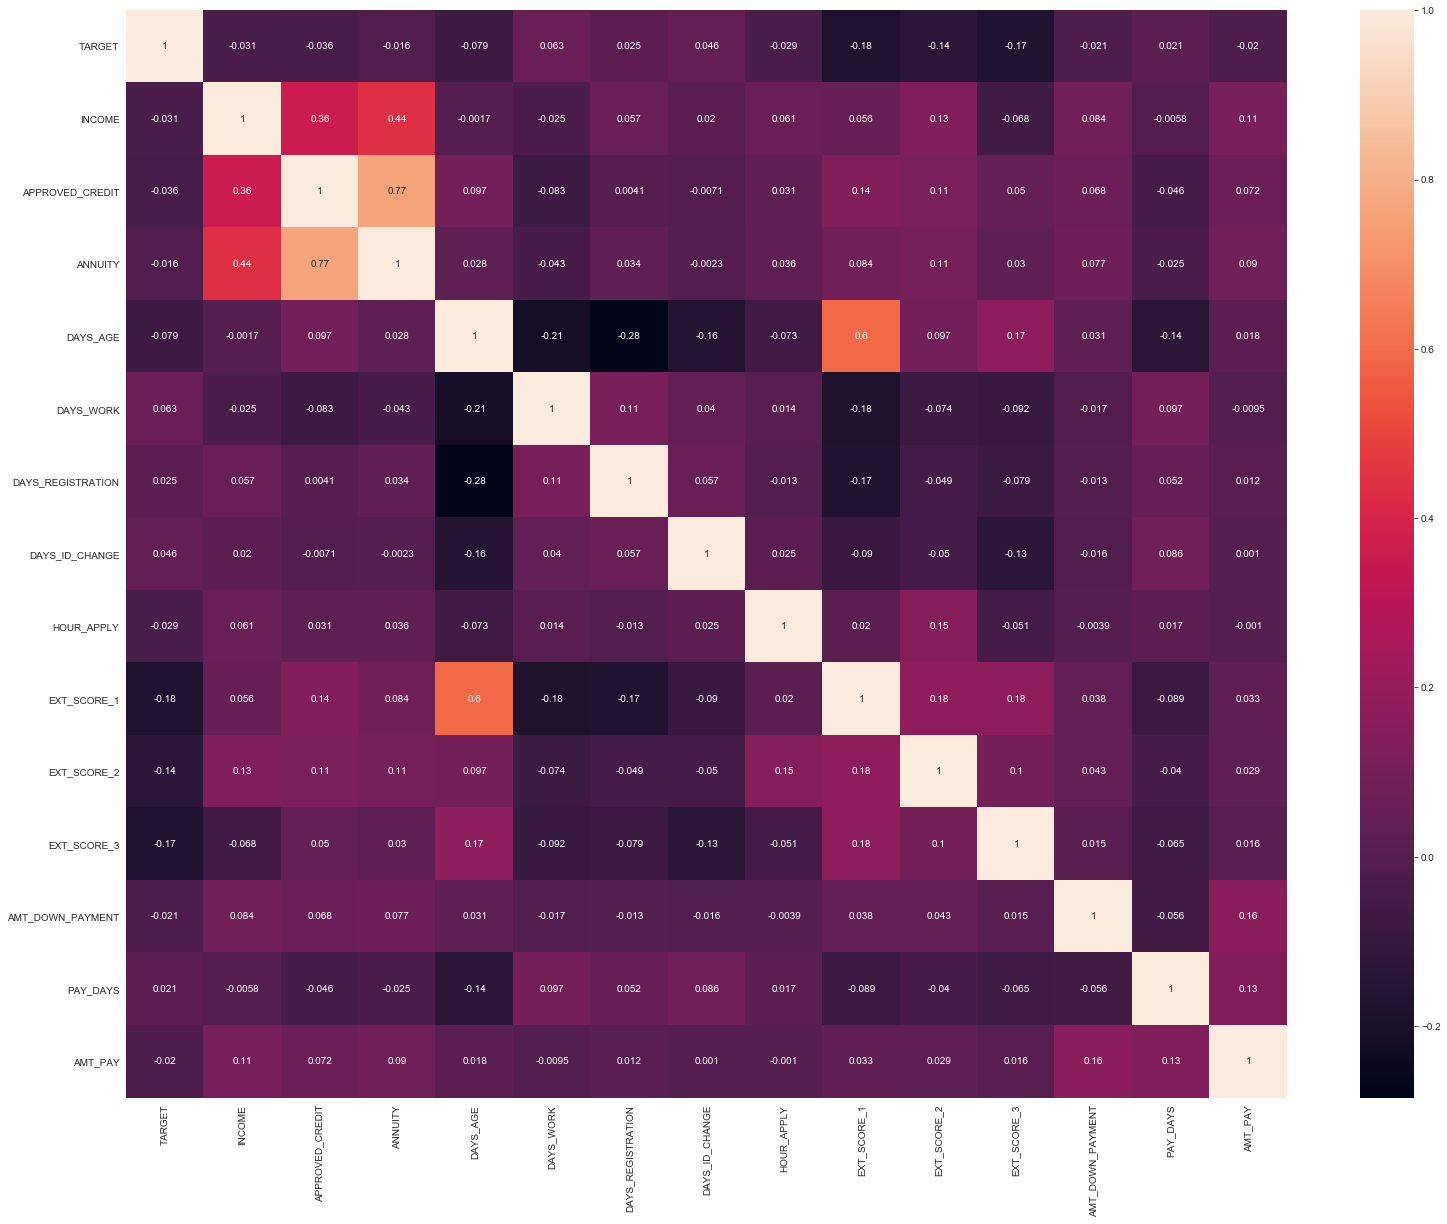

In [84]:
import seaborn as sb
plt.figure(figsize=(26,20))
sb.heatmap(app_train.corr(),annot=True)
plt.show()

### Column Types

Let's look at the number of columns of each data type. int64 and float64 are numeric variables, object columns contain strings and are categorical features.

In [85]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    11
object      8
int64       4
dtype: int64

Let's now look at the number of unique entries in each of the object (categorical) columns.

In [86]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

CONTRACT_TYPE      2
GENDER             2
INCOME_TYPE        7
EDUCATION          5
FAMILY_STATUS      5
HOUSING_TYPE       6
CONTRACT_STATUS    1
YIELD_GROUP        5
dtype: int64

Since we see that CONTRACT_STATUS have only 1 value, it means the feature can we drop

In [87]:
app_train.drop(labels=['CONTRACT_STATUS'], axis=1, inplace=True)
app_test.drop(labels=['CONTRACT_STATUS'], axis=1, inplace=True)

### Encoding Categorical Variables

Let's implement the policy described above: for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding. 

For label encoding, we use the Scikit-Learn (LabelEncoder) and for one-hot encoding, the pandas (get_dummies) function.

In [88]:
# Create a label encoder object
feature_mod = ['CONTRACT_TYPE','GENDER']
encode = LabelEncoder()
for i in feature_mod:
    app_train[i] = encode.fit_transform(app_train[i])
    app_test[i] = encode.fit_transform(app_test[i])

app_train.head()

,TARGET,CONTRACT_TYPE,GENDER,INCOME,APPROVED_CREDIT,ANNUITY,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,...,DAYS_REGISTRATION,DAYS_ID_CHANGE,HOUR_APPLY,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3,AMT_DOWN_PAYMENT,YIELD_GROUP,PAY_DAYS,AMT_PAY
0,0,1,1,135000.0,180000.0,9000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3524.0,-1644,11,0.175511,0.492994,0.085595,27630.0,middle,-1418.0,10198.665
1,0,1,1,135000.0,180000.0,9000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3524.0,-1644,11,0.175511,0.492994,0.085595,27630.0,middle,-1328.0,743.175
2,0,1,1,135000.0,180000.0,9000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3524.0,-1644,11,0.175511,0.492994,0.085595,27630.0,middle,-1473.0,10198.665
3,0,1,1,135000.0,180000.0,9000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3524.0,-1644,11,0.175511,0.492994,0.085595,27630.0,middle,-1296.0,9455.490
4,0,1,1,135000.0,180000.0,9000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3524.0,-1644,11,0.175511,0.492994,0.085595,27630.0,middle,-1448.0,10198.665


In [89]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

INCOME_TYPE      7
EDUCATION        5
FAMILY_STATUS    5
HOUSING_TYPE     6
YIELD_GROUP      5
dtype: int64

In [90]:
# one-hot encoding of categorical variables
catsub1 = app_train[['INCOME_TYPE','EDUCATION','FAMILY_STATUS','HOUSING_TYPE','YIELD_GROUP']]
catsub2 = app_test[['INCOME_TYPE','EDUCATION','FAMILY_STATUS','HOUSING_TYPE','YIELD_GROUP']]

catsub1 = pd.get_dummies(catsub1)
catsub2 = pd.get_dummies(catsub2)

app_train = pd.concat([app_train, catsub1], axis = 1)
app_test = pd.concat([app_test, catsub2], axis = 1)

In [91]:
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (398039, 50)
Testing Features shape:  (95046, 47)


### Aligning Training & Testing Data

There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to align the dataframes.

In [92]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (398039, 47)
Testing Features shape:  (95046, 47)


### Drop feature that has already change by One hot Encoding

In [93]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

INCOME_TYPE      7
EDUCATION        5
FAMILY_STATUS    5
HOUSING_TYPE     6
YIELD_GROUP      5
dtype: int64

In [94]:
app_train.drop(labels=['INCOME_TYPE','EDUCATION','FAMILY_STATUS','HOUSING_TYPE','YIELD_GROUP'], axis=1, inplace=True)
app_test.drop(labels=['INCOME_TYPE','EDUCATION','FAMILY_STATUS','HOUSING_TYPE','YIELD_GROUP'], axis=1, inplace=True)

In [95]:
app_train.columns

Index(['TARGET', 'CONTRACT_TYPE', 'GENDER', 'INCOME', 'APPROVED_CREDIT',
       'ANNUITY', 'DAYS_AGE', 'DAYS_WORK', 'DAYS_REGISTRATION',
       'DAYS_ID_CHANGE', 'HOUR_APPLY', 'EXT_SCORE_1', 'EXT_SCORE_2',
       'EXT_SCORE_3', 'AMT_DOWN_PAYMENT', 'PAY_DAYS', 'AMT_PAY',
       'INCOME_TYPE_Commercial associate', 'INCOME_TYPE_Pensioner',
       'INCOME_TYPE_State servant', 'INCOME_TYPE_Working',
       'EDUCATION_Academic degree', 'EDUCATION_Higher education',
       'EDUCATION_Incomplete higher', 'EDUCATION_Lower secondary',
       'EDUCATION_Secondary / secondary special',
       'FAMILY_STATUS_Civil marriage', 'FAMILY_STATUS_Married',
       'FAMILY_STATUS_Separated', 'FAMILY_STATUS_Single / not married',
       'FAMILY_STATUS_Widow', 'HOUSING_TYPE_Co-op apartment',
       'HOUSING_TYPE_House / apartment', 'HOUSING_TYPE_Municipal apartment',
       'HOUSING_TYPE_Office apartment', 'HOUSING_TYPE_Rented apartment',
       'HOUSING_TYPE_With parents', 'YIELD_GROUP_NA1', 'YIELD_GROUP_hig

In [96]:
print(app_train.shape)
print(app_test.shape)

(398039, 42)
(95046, 42)


# Baseline

Actually there are several ways to deal with imbalanced dataset

- Change the performance metrics
- Change the algorithm
- Resampling technique (under-sampling, over-sampling) 
- Generate synthetic sample

But in this case, I will try several ensemble methods model to deal with it. [More details](https://imbalanced-learn.readthedocs.io/en/stable/api.html#module-imblearn.ensemble)

### Split Dataset Into X & Y Variable

In [97]:
# seperate the independent and target variable on training data
train_x = app_train.drop(columns=['TARGET'],axis=1)
train_y = app_train['TARGET']

# seperate the independent and target variable on testing data
test_x = app_test.drop(columns=['TARGET'],axis=1)
test_y = app_test['TARGET']

print('shape of training data : ',train_x.shape)
print('shape of testing data : ',test_x.shape)

shape of training data :  (398039, 41)
shape of testing data :  (95046, 41)


In [98]:
bagging = BalancedBaggingClassifier()
bagging = bagging.fit(train_x,train_y)

rusboost = RUSBoostClassifier()
rusboost = rusboost.fit(train_x,train_y)

random = BalancedRandomForestClassifier()
random = random.fit(train_x,train_y)

easy = EasyEnsembleClassifier()
easy = easy.fit(train_x,train_y)

### Model Accuracy

#### What is Cross Validation?

Cross Validation is a technique which involves reserving a particular sample of a dataset on which you do not train the model. Later, we test the model on this sample before finalizing it. I also using cross-validation to check if the score is stable and not overfitting

In [99]:
bagging_acc_cv = cross_val_score(bagging,test_x,test_y, scoring='accuracy', cv=5)*100
bagging_acc_cv1 = bagging_acc_cv.mean()
print('Balanced Bagging accuracy score after cross validation',bagging_acc_cv1,'%')

Balanced Bagging accuracy score after cross validation 91.55357866559457 %


In [100]:
rusboost_acc_cv = cross_val_score(rusboost,test_x,test_y, scoring='accuracy', cv=5)*100
rusboost_acc_cv1 = rusboost_acc_cv.mean()
print('RUSBoost accuracy score after cross validation',rusboost_acc_cv1,'%')

RUSBoost accuracy score after cross validation 73.37603348495546 %


In [101]:
random_acc_cv = cross_val_score(random,test_x,test_y,scoring='accuracy', cv=5)*100
random_acc_cv1 = random_acc_cv.mean()
print('Balanced Random Forrest accuracy after cross validation',random_acc_cv1,'%')

Balanced Random Forrest accuracy after cross validation 92.85925095034443 %


In [102]:
easy_acc_cv = cross_val_score(easy,test_x,test_y,scoring='accuracy', cv=5)*100
easy_acc_cv1 = easy_acc_cv.mean()
print('Easy Ensemble accuracy after cross validation',easy_acc_cv1,'%')

Easy Ensemble accuracy after cross validation 73.59279085637029 %


We also know that it makes leads to bias if we only consider the model just looking from the accuracy. So, I need to look confusion matrix and ROC-AUC curve to pick the best model

### Comparison of the total approved credit

In [103]:
dfLate = app_train[app_train['TARGET']==1].reset_index(drop=True)
dfOntime = app_train[app_train['TARGET']==0].reset_index(drop=True)

In [104]:
print("Total approved credit based on customers with late payment :", dfLate['APPROVED_CREDIT'].sum())
print("Total approved credit based on customers with on-time payment :", dfOntime['APPROVED_CREDIT'].sum())

Total approved credit based on customers with late payment : 15120351117.0
Total approved credit based on customers with on-time payment : 231870674740.5


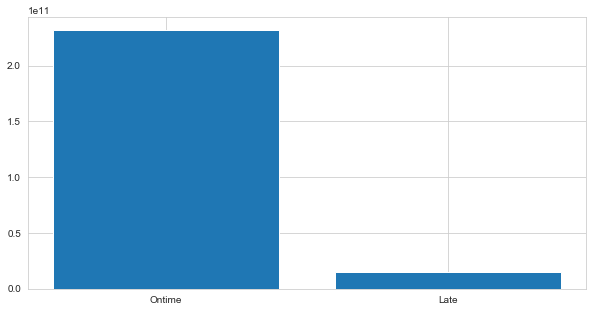

In [105]:
late = dfLate['APPROVED_CREDIT'].sum()
ontime = dfOntime['APPROVED_CREDIT'].sum()

x = np.arange(2)
credit = [ontime, late]

plt.figure(figsize=(10,5))
plt.bar(x, credit)
plt.xticks(x, ('Ontime', 'Late'))
plt.show()

##### Insight

- We could see that the total of approved credit in customer's on-time payment is 12x higher than customer's with late payment
- We also can decide in the confusion matrix, parameters that we should be focused on predict a customer's with on-time payment, considered by the potential of approved credit loss if we're much focused on predicting the customer's with late payment 

### Model Classification Matrix

In [106]:
print('Classification report Balanced Bagging classifier:\n',classification_report(test_y,bagging.predict(test_x)))

Classification report Balanced Bagging classifier:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     88633
           1       0.21      0.06      0.10      6413

    accuracy                           0.92     95046
   macro avg       0.57      0.52      0.53     95046
weighted avg       0.89      0.92      0.90     95046



In [107]:
print('Classification report Balanced Random Forest classifier:\n',classification_report(test_y,random.predict(test_x)))

Classification report Balanced Random Forest classifier:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96     88633
           1       0.21      0.04      0.06      6413

    accuracy                           0.93     95046
   macro avg       0.57      0.51      0.51     95046
weighted avg       0.89      0.93      0.90     95046



In [108]:
print('Classification report RUSBoost classifier:\n',classification_report(test_y,rusboost.predict(test_x)))

Classification report RUSBoost classifier:
               precision    recall  f1-score   support

           0       0.96      0.72      0.82     88633
           1       0.14      0.61      0.22      6413

    accuracy                           0.71     95046
   macro avg       0.55      0.67      0.52     95046
weighted avg       0.91      0.71      0.78     95046



In [109]:
print('Classification report Easy Ensemble classifier:\n',classification_report(test_y,easy.predict(test_x)))

Classification report Easy Ensemble classifier:
               precision    recall  f1-score   support

           0       0.96      0.73      0.83     88633
           1       0.14      0.60      0.22      6413

    accuracy                           0.72     95046
   macro avg       0.55      0.66      0.53     95046
weighted avg       0.91      0.72      0.79     95046



From above, I decided to choose Easy Ensemble Classifier as the best model comparing than any other models because they can good interpret TARGET==1 more than Balanced Bagging and Random Forrest Classifier, and also have an F1 Score more than RUSBoost Classifier

In [111]:
tn_easy, fp_easy, fn_easy, tp_easy = confusion_matrix(test_y,easy.predict(test_x)).ravel()
print('True negative:', tn_easy)
print('False positive:', fp_easy)
print('False negative:', fn_easy)
print('True positive:', tp_easy)

True negative: 64471
False positive: 24162
False negative: 2591
True positive: 3822


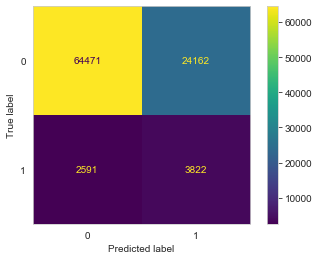

In [112]:
plot_confusion_matrix(easy,test_x,test_y,values_format='0.0f')
plt.grid(False)
plt.show()

We can see from above that the model still has a high value of True Negative (Because in this case 0 means customers with on-time payment) more than the value of False Positif, and also can predict the value of True Positive more than False Negative. It means that the model can balance to both predict clients with on-time and late payment without only focused on True Negative (Since the total credit of clients with on-time payment 12x higher than clients with late payment)

### Model AUC - ROC

AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, Higher the AUC, better the model is at distinguishing between clients with ontime payment and late payment.

In [113]:
easy_pred_prob = easy.predict_proba(test_x)
print('Easy ensemble AUC score =',roc_auc_score(test_y, easy_pred_prob[:,1]))

Easy ensemble AUC score = 0.7333746925724475


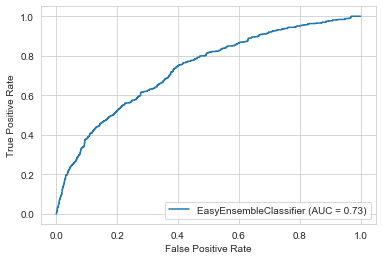

In [114]:
plot_roc_curve(easy,test_x,test_y)
plt.show()

## Recommendations 

- More details about EXT_SCORE features will help to develop the model
- Consider to including clients status for previous loan payment(on-time/late) and make a stable ID for one user to another as they current & previous payment to see the track records on repaying a loan and oversee the potential risk 